In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2016_part_3_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2017_part_32_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2021_part_22_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2016_part_10_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2019_part_25_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2019_part_31_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2021_part_9_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2019_part_20_game_info.csv
/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/updated_games_2020_part_12_game_info.csv
/kaggle/input/chess-middle-gam

In [2]:
# libraries

import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [3]:
def calculate_term_frequency(moves_str, constellation_size):
    # Split moves string into individual moves
    moves = moves_str.split('|')
    # Create constellations of the specified size
    constellations = ['|'.join(moves[i:i+constellation_size]) for i in range(len(moves) - constellation_size + 1)]
    # Count the frequency of each constellation
    return Counter(constellations)

def create_frequency_distribution_df(data, constellation_size):
    # Initialize a counter for all term frequencies
    all_term_frequencies = Counter()
    # Calculate term frequencies for each moves string
    for moves_str in data['middle_game_moves']:
        term_frequencies = calculate_term_frequency(moves_str, constellation_size)
        all_term_frequencies.update(term_frequencies)
    # Create a DataFrame from the term frequencies
    frequency_counts = pd.DataFrame(all_term_frequencies.items(), columns=['Constellation', 'Frequency'])
    # Count how many constellations have each frequency
    frequency_distribution = frequency_counts['Frequency'].value_counts().sort_index()
    # Convert to DataFrame for easier manipulation
    frequency_distribution_df = frequency_distribution.reset_index()
    frequency_distribution_df.columns = ['Frequency', f'Constellation Size {constellation_size}']
    return frequency_distribution_df

def process_all_files_and_merge(directory, constellation_sizes):
    distribution_dfs = []
    
    for size in constellation_sizes:
        data = pd.DataFrame()
        # Loop through all CSV files in the directory
        files = [f for f in os.listdir(directory) if f.endswith('.csv')]
        for file in files:
            full_path = os.path.join(directory, file)
            df = pd.read_csv(full_path)
            if 'middle_game_moves' not in df.columns:
                raise ValueError(f"Column 'middle_game_moves' does not exist in {file}.")
            data = pd.concat([data, df], ignore_index=True)
        
        distribution_df = create_frequency_distribution_df(data, size)
        distribution_dfs.append(distribution_df)

    # Merge the DataFrames on the 'Frequency' column and handle outer join
    frequency_distribution_table = distribution_dfs[0]
    for df in distribution_dfs[1:]:
        frequency_distribution_table = frequency_distribution_table.merge(df, on='Frequency', how='outer')

    # Fill NaN values with 0 and adjust table formatting
    frequency_distribution_table = frequency_distribution_table.fillna(0).set_index('Frequency').sort_index()

    # Save the combined frequency distribution table
    combined_table_path = "/kaggle/working/combined_frequency_distribution.csv"
    frequency_distribution_table.to_csv(combined_table_path)

    return frequency_distribution_table

# Define constellation sizes and directory
constellation_sizes = [11]
directory = "/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/"

# Process files and merge DataFrames
try:
    frequency_distribution_table = process_all_files_and_merge(directory, constellation_sizes)
    print(frequency_distribution_table)
except ValueError as e:
    print(e)
    
# Calculate the total number of constellations recorded
total_constellation_size_11 = frequency_distribution_table['Constellation Size 11'].sum()

print(f'Total number of constellations recorded: {total_constellation_size_11}')

           Constellation Size 11
Frequency                       
1                       89273196
2                         143790
3                          29100
4                          12511
5                           6810
...                          ...
407                            1
408                            1
416                            1
475                            1
636                            1

[210 rows x 1 columns]
Total number of constellations recorded: 89483468


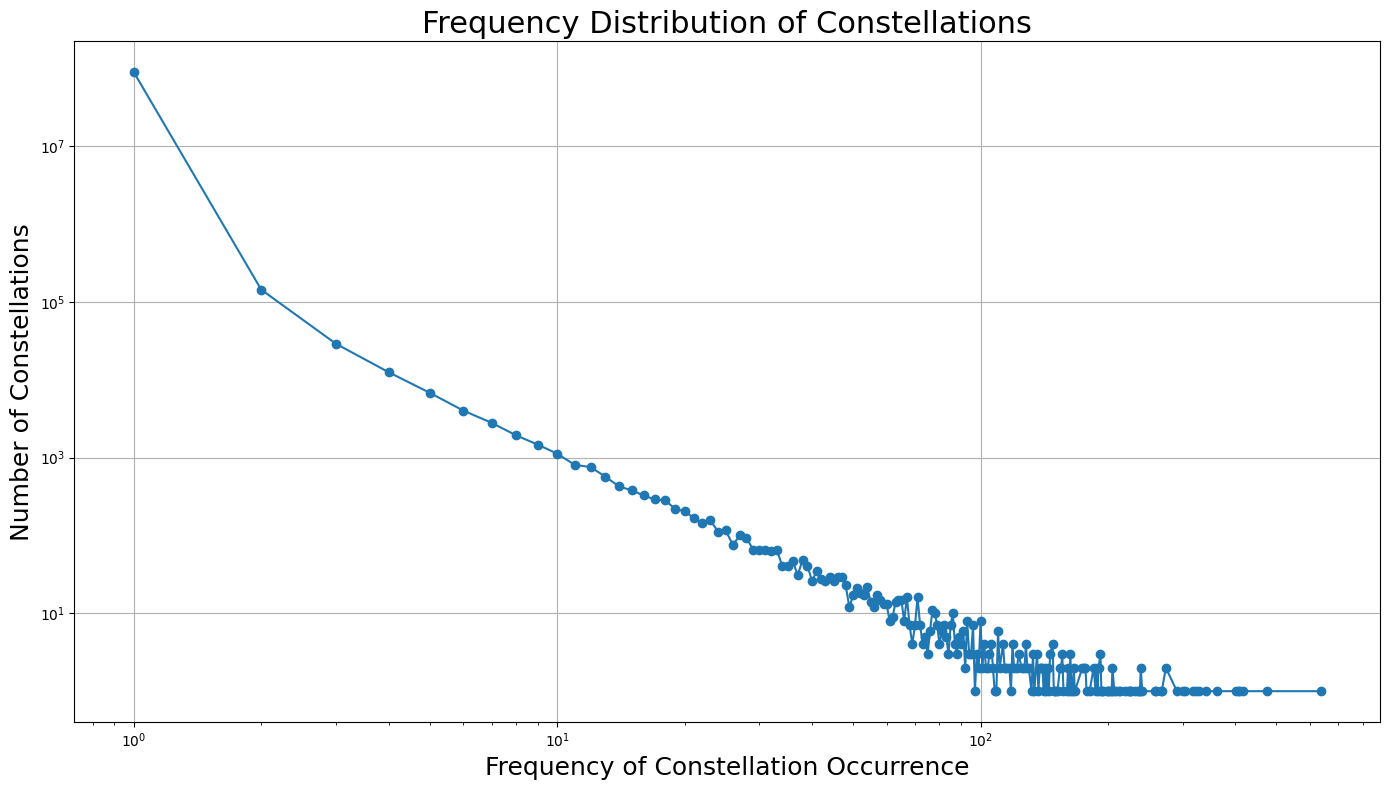

In [4]:
plt.figure(figsize=(14, 8))
for column in frequency_distribution_table.columns:
    plt.plot(frequency_distribution_table.index, frequency_distribution_table[column], marker='o', label=column)

plt.title('Frequency Distribution of Constellations', fontsize=22)
plt.xlabel('Frequency of Constellation Occurrence', fontsize=18)
plt.ylabel('Number of Constellations', fontsize=18)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [5]:
# Directory path
directory = "/kaggle/input/chess-middle-game-all-data/Combined Middle Game Data/"

# Select all CSV files
files = [f for f in os.listdir(directory) if f.endswith('_game_info.csv')]

# Initialize an empty DataFrame to concatenate data from each file
valid_chess_data = pd.DataFrame()

# Load and concatenate data from each CSV file
for file in files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    valid_chess_data = pd.concat([valid_chess_data, df], ignore_index=True)

# Initialize dictionary for term frequencies
all_term_frequencies = Counter()
valid_chess_data['middle_game_moves'].apply(lambda moves: all_term_frequencies.update(calculate_term_frequency(moves, 11)))

# Apply cutoff to filter constellations
cutoff_frequency = 21
filtered_constellations = {constellation: freq for constellation, freq in all_term_frequencies.items() if freq >= cutoff_frequency}

# Calculate IDF for filtered constellations
N = len(valid_chess_data)
filtered_constellation_idf = {constellation: np.log(N / freq) for constellation, freq in filtered_constellations.items()}

# The IDF scores are directly used without further normalization or weighting
constellation_idf_scores = filtered_constellation_idf

# Create DataFrame for IDF scores and save to CSV
constellation_idf_df = pd.DataFrame(list(constellation_idf_scores.items()), columns=['Constellation', 'IDF'])
constellation_idf_df.to_csv('constellation_idf_scores.csv', index=False)

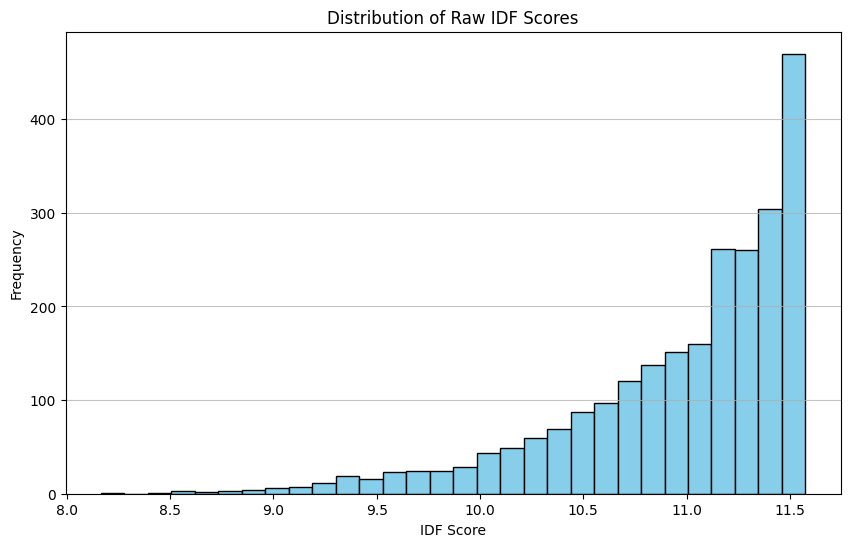

In [6]:
# Convert raw IDF scores to a list for plotting
raw_idf_scores = list(filtered_constellation_idf.values())

# Plotting the distribution of raw IDF scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(raw_idf_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Raw IDF Scores')
plt.xlabel('IDF Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
# Create a mapping from each unique constellation string to its IDF score
constellation_to_idf = pd.Series(constellation_idf_df.IDF.values, index=constellation_idf_df.Constellation).to_dict()

# Generate unique IDs for each player
all_players = pd.concat([valid_chess_data['white'], valid_chess_data['black']]).unique()
player_to_id = {player: i for i, player in enumerate(all_players)}

# Initialize a list to store the data
data_for_analysis = []

# Process each game in valid chess data
for index, row in valid_chess_data.iterrows():
    game_id = row['game_id']
    date_played = row['date_played']
    start_middle_game_ply = row['start_middle_game_ply']
    moves = row['middle_game_moves']
    white_player = row['white']  
    black_player = row['black'] 
    white_elo = row['white_elo']
    black_elo = row['black_elo']
    result = row['result']

    # Get player IDs
    white_id = player_to_id[white_player]
    black_id = player_to_id[black_player]

    # Iterate through the moves to find constellations
    for i in range(len(moves.split('|')) - 10):
        constellation = '|'.join(moves.split('|')[i:i+11])
        if constellation in constellation_to_idf:
            idf = constellation_to_idf[constellation]
            constellation_ply = start_middle_game_ply + i
            player_made = 'White' if constellation_ply % 2 != 0 else 'Black'
            
            # Append the game details along with the constellation idf
            data_for_analysis.append({
                'game_id': game_id,
                'date_played': date_played,
                'constellation_ply': constellation_ply,
                'constellation_str': constellation,
                'idf': idf,
                'white_elo': white_elo,
                'black_elo': black_elo,
                'result': result,
                'player_made': player_made,
                'white_id': white_id,  # Encoded ID for the player in 'white'
                'black_id': black_id,  # Encoded ID for the player in 'black'
            })

# Convert the list to a DataFrame
ctp_analysis_df = pd.DataFrame(data_for_analysis)

# Save the DataFrame for further analysis
ctp_analysis_df.to_csv('ctp_analysis_df.csv', index=False)